## Importations

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
import configparser
import datetime
import sys
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import seaborn as sns
import re
from pprint import pprint
import gensim
import spacy
import logging
import warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from operator import itemgetter
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import spacy
import fr_core_news_md
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models.nmf import Nmf

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/anaconda3/envs/analytics/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Configuration

In [2]:
nlp = fr_core_news_md.load()

In [3]:
config = configparser.ConfigParser()
config.read('../config/default.ini')

['../config/default.ini']

In [4]:
engine = sql.create_engine('postgresql://{}:{}@{}:{}/{}'.format(config['DATABASE']['username'], config['DATABASE']['password'].replace('_percentage_', '%'), config['DATABASE']['host'], config['DATABASE']['port'], config['DATABASE']['database']))

## Utilitaires

In [5]:
def export_df(df, name):
    df.to_csv('output/{}_{}.csv'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d'), name), index=False, encoding='utf-8-sig')

In [6]:
def clean_html(raw_html):    
    cleanhmtl = re.compile('<.*?>')
    raw_html = raw_html.replace('\n', ' ')
    cleantext = re.sub(cleanhmtl, '', raw_html)
    return cleantext

In [7]:
def sent_to_words(sentences):
    for sent in sentences:
        yield(gensim.utils.simple_preprocess(str(sent), deacc=True)) 

In [8]:
def process_words(texts, stop_words=nlp.Defaults.stop_words, allowed_postags=['NOUN', 'ADJ', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [9]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

## Données

In [10]:
df_articles_paragraph = pd.read_sql_query("""SELECT art.id, art.title, par.body FROM article_article art INNER JOIN article_paragraph par ON art.id = par.articleid WHERE published = '1' AND displaydate >= '2019-03-01' AND displaydate <= '2019-03-10'""", engine)
df_articles_paragraph.head()

id                                              title  \
0  10155953  R66 Teasing : Patsy Cline – John Carter Cash –...   
1  10157957  Chédigny, le village-jardin aux 1000 rosiers e...   
2  10158918  Carnaval 2019: de Binche à Malmedy, les événem...   
3  10160431  L'Avion qui vole avec le Soleil : l'odyssée de...   
4  10161124    Mustii devient Hamlet dans " C'est du Belge " !   

                                                body  
0  <p><span><span><span><span><span>Des vedettes ...  
1                                                     
2  <p><span><span><span><span><span>La 561ème édi...  
3  <p><span><span>C’est un livre qui a choisi la ...  
4  <p><strong>"C'est du Belge", à suivre ce vendr...

In [11]:
export_df(df_articles_paragraph, 'articles')

In [81]:
df_articles_paragraph['body'] = df_articles_paragraph['body'].apply(lambda x: clean_html(x))
df_articles_paragraph.head()

id                                              title  \
0  10155916       Concours: vos entrées pour le Spa Rally 2019   
1  10158918  Carnaval 2019: de Binche à Malmedy, les événem...   
2  10160425  Le Dimanche-Gras a lancé trois jours de festiv...   
3  10161188  Tex, pour la première fois au Festival du Rire...   
4  10161414  "Julie et Julia" : Film au croisement de deux ...   

                                                body  
0                                                     
1  L’un des carnavals le plus important de Wallon...  
2                                                     
3  ..... "Les Apéros du Rire".  Un concept simple...  
4  Comme vous pouviez vous en doutez, la cuisine ...

In [82]:
df_articles = df_articles_paragraph.groupby(by=['id', 'title'])['body'].apply(lambda x: ' '.join(x)).reset_index()
df_articles.head()

id                                              title  \
0  8061732                           Les Liaisons Dangereuses   
1  8226512  Liège-Bastogne-Liège 1999: Vandenbroucke attei...   
2  9067466  Le « Capitaine Marleau » fait face à Gérard De...   
3  9083819                     Un jardin médaille d'or à Dave   
4  9166627             Francis Peeters - Nicotiana sylvestris   

                                                body  
0  Considéré comme la meilleure adaptation du rom...  
1  Très à l'aise dans La Redoute, Vandenbroucke c...  
2                                                     
3                                                     
4   C’est une plante qui n’est pas difficile à vi...

In [83]:
df_articles.count()

id       7160
title    7160
body     7160
dtype: int64

In [30]:
df_articles.shape

(11077, 9)

In [85]:
df_articles.isnull().any()

id       False
title    False
body     False
dtype: bool

---
## Tokenizing 

In [12]:
df_articles = pd.read_csv('output/200916_articles_tokenized_body.csv'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d')))
df_articles['word_list'] = df_articles['word_list'].apply(lambda x: x.strip("']['").split("', '"))
df_articles['processed_words'] = df_articles['processed_words'].apply(lambda x: x.strip("']['").split("', '"))
#df_articles['corpus'] = df_articles['corpus'].apply(lambda x: x.strip("']['").split("', '"))
df_articles.head()

id                                              title  \
0  8061732                           Les Liaisons Dangereuses   
1  8183963  Il y a 15 ans, à l'Open d'Australie, Henin bat...   
2  8210435        Canada 1989: La première de Thierry Boutsen   
3  8214259  Recette de Candice : Gratin de pâtes de fin d'...   
4  8226512  Liège-Bastogne-Liège 1999: Vandenbroucke attei...   

                                                body  \
0  Considéré comme la meilleure adaptation du rom...   
1  Une finale disputée et un point contesté Contr...   
2  Mais à trois tours de la fin de la course, le ...   
3  500g de rigatoni (ou autres pâtes au choix) \t...   
4  Très à l'aise dans La Redoute, Vandenbroucke c...   

                                           word_list  \
0  [considere, comme, la, meilleure, adaptation, ...   
1  [une, finale, disputee, et, un, point, contest...   
2  [mais, trois, tours, de, la, fin, de, la, cour...   
3  [de, rigatoni, ou, autres, pates, au, choix, d...   
4  [tres, aise, dans, la, redoute, vandenbroucke,...   

                                     processed_words  word_count  \
0  [meilleur, adaptation, roman, choderlo, drame,...          35   
1  [finale, contrairement, precedente, finale, fa...          75   
2  [tour, fin, course, decide, improbable, produi...          43   
3  [chou, bruxelle, frais, coupe, cubes, gouda, c...          57   
4  [aise, redoute, double, attaque, hauteur, dans...          37   

                                              corpus  
0  [(1, 1), (3, 1), (8, 1), (11, 1), (13, 1), (20...  
1  [(81, 1), (85, 1), (93, 3), (95, 1), (96, 1), ...  
2  [(86, 1), (136, 1), (216, 2), (220, 2), (224, ...  
3  [(136, 1), (238, 1), (285, 1), (286, 1), (288,...  
4  [(220, 1), (349, 1), (351, 1), (353, 3), (356,...

---

In [87]:
df_articles['word_list'] = list(sent_to_words(df_articles.body.values.tolist()))
df_articles.head()

id                                              title  \
0  8061732                           Les Liaisons Dangereuses   
1  8226512  Liège-Bastogne-Liège 1999: Vandenbroucke attei...   
2  9067466  Le « Capitaine Marleau » fait face à Gérard De...   
3  9083819                     Un jardin médaille d'or à Dave   
4  9166627             Francis Peeters - Nicotiana sylvestris   

                                                body  \
0  Considéré comme la meilleure adaptation du rom...   
1  Très à l'aise dans La Redoute, Vandenbroucke c...   
2                                                      
3                                                      
4   C’est une plante qui n’est pas difficile à vi...   

                                           word_list  
0  [considere, comme, la, meilleure, adaptation, ...  
1  [tres, aise, dans, la, redoute, vandenbroucke,...  
2                                                 []  
3                                                 []  
4  [est, une, plante, qui, est, pas, difficile, v...

In [88]:
bigram = gensim.models.Phrases(df_articles['word_list'], min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[df_articles['word_list']], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [89]:
df_articles['processed_words'] = process_words(df_articles['word_list'])
df_articles.head()

id                                              title  \
0  8061732                           Les Liaisons Dangereuses   
1  8226512  Liège-Bastogne-Liège 1999: Vandenbroucke attei...   
2  9067466  Le « Capitaine Marleau » fait face à Gérard De...   
3  9083819                     Un jardin médaille d'or à Dave   
4  9166627             Francis Peeters - Nicotiana sylvestris   

                                                body  \
0  Considéré comme la meilleure adaptation du rom...   
1  Très à l'aise dans La Redoute, Vandenbroucke c...   
2                                                      
3                                                      
4   C’est une plante qui n’est pas difficile à vi...   

                                           word_list  \
0  [considere, comme, la, meilleure, adaptation, ...   
1  [tres, aise, dans, la, redoute, vandenbroucke,...   
2                                                 []   
3                                                 []   
4  [est, une, plante, qui, est, pas, difficile, v...   

                                     processed_words  
0  [meilleur, adaptation, roman, choderlo, drame,...  
1  [aise, redoute, double, attaque, hauteur, dans...  
2                                                 []  
3                                                 []  
4  [plante, difficile, terre, riche, plante, bois...

In [90]:
df_articles['word_count'] = df_articles['processed_words'].str.len()
df_articles.head()

id                                              title  \
0  8061732                           Les Liaisons Dangereuses   
1  8226512  Liège-Bastogne-Liège 1999: Vandenbroucke attei...   
2  9067466  Le « Capitaine Marleau » fait face à Gérard De...   
3  9083819                     Un jardin médaille d'or à Dave   
4  9166627             Francis Peeters - Nicotiana sylvestris   

                                                body  \
0  Considéré comme la meilleure adaptation du rom...   
1  Très à l'aise dans La Redoute, Vandenbroucke c...   
2                                                      
3                                                      
4   C’est une plante qui n’est pas difficile à vi...   

                                           word_list  \
0  [considere, comme, la, meilleure, adaptation, ...   
1  [tres, aise, dans, la, redoute, vandenbroucke,...   
2                                                 []   
3                                                 []   
4  [est, une, plante, qui, est, pas, difficile, v...   

                                     processed_words  word_count  
0  [meilleur, adaptation, roman, choderlo, drame,...          35  
1  [aise, redoute, double, attaque, hauteur, dans...          37  
2                                                 []           0  
3                                                 []           0  
4  [plante, difficile, terre, riche, plante, bois...          56

In [91]:
df_articles = df_articles[df_articles['word_count'] > 0]
df_articles.shape

(4847, 6)

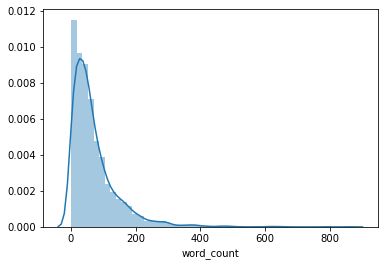

In [92]:
sns.distplot(df_articles[df_articles['word_count'] > 0]['word_count'])

In [13]:
id2word = corpora.Dictionary(df_articles['processed_words'])

In [14]:
df_articles['corpus'] = df_articles['processed_words'].apply(lambda x: id2word.doc2bow(x))
df_articles.head()

id                                              title  \
0  8061732                           Les Liaisons Dangereuses   
1  8183963  Il y a 15 ans, à l'Open d'Australie, Henin bat...   
2  8210435        Canada 1989: La première de Thierry Boutsen   
3  8214259  Recette de Candice : Gratin de pâtes de fin d'...   
4  8226512  Liège-Bastogne-Liège 1999: Vandenbroucke attei...   

                                                body  \
0  Considéré comme la meilleure adaptation du rom...   
1  Une finale disputée et un point contesté Contr...   
2  Mais à trois tours de la fin de la course, le ...   
3  500g de rigatoni (ou autres pâtes au choix) \t...   
4  Très à l'aise dans La Redoute, Vandenbroucke c...   

                                           word_list  \
0  [considere, comme, la, meilleure, adaptation, ...   
1  [une, finale, disputee, et, un, point, contest...   
2  [mais, trois, tours, de, la, fin, de, la, cour...   
3  [de, rigatoni, ou, autres, pates, au, choix, d...   
4  [tres, aise, dans, la, redoute, vandenbroucke,...   

                                     processed_words  word_count  \
0  [meilleur, adaptation, roman, choderlo, drame,...          35   
1  [finale, contrairement, precedente, finale, fa...          75   
2  [tour, fin, course, decide, improbable, produi...          43   
3  [chou, bruxelle, frais, coupe, cubes, gouda, c...          57   
4  [aise, redoute, double, attaque, hauteur, dans...          37   

                                              corpus  
0  [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...  
1  [(30, 1), (31, 2), (32, 1), (33, 2), (34, 3), ...  
2  [(83, 1), (84, 1), (85, 2), (86, 2), (87, 1), ...  
3  [(90, 1), (96, 1), (97, 1), (117, 1), (118, 1)...  
4  [(86, 1), (146, 1), (156, 1), (157, 2), (158, ...

In [25]:
export_df(df_articles, 'articles_tokenized_body')

In [13]:
vocab_tf = [dict(i) for i in df_articles['corpus']]
#tf_idf = pd.DataFrame(vocab_tf)

In [15]:
#export_df(tf_idf, 'tf_idf')

In [ ]:
word_freq = list(pd.DataFrame(vocab_tf).sum(axis=0))

In [98]:
tf_idf

1      3      8      11     13     20     25     26     29     31     \
0       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
1       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4       1.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    1.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4842    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4843    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4844    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4845    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    1.0   
4846    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

      ...  54854  56999  3078   58724  58726  58728  58731  5103   21012  \
0     ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1     ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3     ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4     ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4842  ...    NaN    NaN    1.0    1.0    1.0    1.0    NaN    NaN    NaN   
4843  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4844  ...    NaN    NaN    NaN    NaN    NaN    NaN    1.0    NaN    NaN   
4845  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    2.0    1.0   
4846  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

      58746  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
4842    NaN  
4843    NaN  
4844    NaN  
4845    1.0  
4846    NaN  

[4847 rows x 20814 columns]

In [1]:
df_dictionary = pd.DataFrame([({id2word[i]: val}) for i, val in enumerate(word_freq)])
df_dictionary.head()

NameError: name 'pd' is not defined

In [111]:
df_articles[df_articles.apply(lambda x: len([x for x in x['processed_words'] if x == 'acteur']), axis=1) > 0].a

id                                              title  \
0      8061732                           Les Liaisons Dangereuses   
11     9516668                  Tom Cruise proche d'être décapité   
24    10109848  L'incroyable Howard Huges incarné par Léonardo...   
82    10157067  Gilets jaunes, Jeunes pour le climat, Gang des...   
120   10158793  Décès du musicien américain André Previn, quat...   
...        ...                                                ...   
7030  10232840               Wakeman va jouer Bowie & Les Beatles   
7081  10233560  "Rocketman", le biopic sur Elton John tant att...   
7100  10233662  "Le pont des oubliés" : un polar au grand air ...   
7113  10233767  Jean-Pierre Jeunet : l'incroyable conteur d'Am...   
7118  10233803                  La Semaine Bio dès ce 1er juin !    

                                                   body  \
0     Considéré comme la meilleure adaptation du rom...   
11    Pour les besoins du film, Tom Cruise s'est ent...   
24    Catt Blanchett prêta ses traits à Katharine He...   
82       Le tirage au sort a quelque chose d’innovan...   
120   Le compositeur, chef d'orchestre et interprète...   
...                                                 ...   
7030  Rick Wakeman apparaîtra dans " Electronic Voya...   
7081  Sinan vient tout juste de terminer ses études ...   
7100  Au cœur des alpages, un berger est assassiné. ...   
7113  Dans les films de Jeunet, les personnages sont...   
7118  La Semaine bio est un moment de rencontres ent...   

                                              word_list  \
0     [considere, comme, la, meilleure, adaptation, ...   
11    [pour, les, besoins, du, film, tom, cruise, es...   
24    [catt, blanchett, preta, ses, traits, katharin...   
82    [le, tirage, au, sort, quelque, chose, innovan...   
120   [le, compositeur, chef, orchestre, et, interpr...   
...                                                 ...   
7030  [rick, wakeman, apparaitra, dans, electronic, ...   
7081  [sinan, vient, tout, juste, de, terminer, ses,...   
7100  [au, cœur, des, alpages, un, berger, est, assa...   
7113  [dans, les, films, de, jeunet, les, personnage...   
7118  [la, semaine, bio, est, un, moment, de, rencon...   

                                        processed_words  word_count  \
0     [meilleur, adaptation, roman, choderlo, drame,...          35   
11    [besoin, film, an, raison, jour, musculatur, s...          61   
24    [trait, fort, temperament, role, directive, do...         110   
82    [tirage, chose, innovant, amandine, cadrage, c...          92   
120   [compositeur, germano, americain, jeudi, ag, a...         123   
...                                                 ...         ...   
7030  [electronic, documentaire, vie, moog, compagni...          91   
7081  [sinan, etude, professeur, vite, job, travail,...         181   
7100  [cœur, alpage, berger, assassine, village, ent...          73   
7113  [film, jeunet, personnage, opprime, ban, socie...         118   
7118  [semaine, bio, moment, rencontre, acteur, sect...          42   

                                                 corpus  
0     [(1, 1), (3, 1), (8, 1), (11, 1), (13, 1), (20...  
11    [(11, 1), (113, 1), (147, 1), (177, 1), (405, ...  
24    [(31, 1), (50, 1), (52, 2), (60, 3), (159, 1),...  
82    [(31, 1), (159, 1), (183, 1), (368, 1), (405, ...  
120   [(159, 1), (172, 1), (193, 1), (281, 1), (383,...  
...                                                 ...  
7030  [(99, 1), (147, 2), (405, 1), (409, 1), (450, ...  
7081  [(3, 1), (20, 1), (31, 2), (52, 2), (61, 3), (...  
7100  [(3, 2), (11, 1), (26, 1), (31, 1), (60, 2), (...  
7113  [(52, 5), (128, 2), (172, 1), (177, 1), (293, ...  
7118  [(128, 1), (131, 1), (405, 1), (541, 1), (615,...  

[280 rows x 7 columns]

In [110]:
id2word[0]

'acteur'

In [30]:
#df_dictionary = pd.DataFrame([{'term': id2word[i], 'frequency': val} for i, val in enumerate(word_freq)])
#df_dictionary.head()

In [31]:
#export_df(df_dictionary, 'dictionary')

In [32]:
#df_dictionary = df_dictionary.sort_values(by='frequency', ascending=False)
#df_dictionary.head()

term  frequency
160    offre     5724.0
76   valmont     4411.0
127     etre     3194.0
310   gratin     3085.0
125    etait     2875.0

In [33]:
#df_dictionary.shape

(31485, 2)

<AxesSubplot:xlabel='frequency', ylabel='term'>

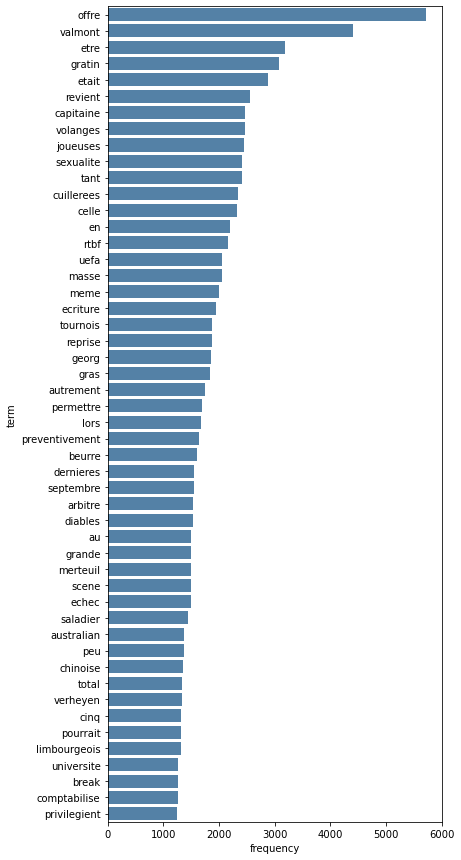

In [34]:
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(x='frequency', y='term', data=df_dictionary.head(50), color='steelblue')

In [13]:
#max_features = int(df_dictionary.shape[0]/2)
max_features = 14000

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=max_features,
    ngram_range=(1, 2),
    preprocessor=' '.join
)
tfidf = tfidf_vectorizer.fit_transform(df_articles['processed_words'])

In [14]:
id2word.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=max_features
)

In [82]:
topic_nums = list(np.arange(5, 200, 5))


In [83]:
all_coherence_scores = coherence_scores.copy()

In [84]:
topic_nums = list(np.arange(5, 50, 1))
coherence_scores = []
for num in topic_nums:
    nmf = Nmf(
        corpus=list(df_articles['corpus']),
        num_topics=num,
        id2word=id2word,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    cm = CoherenceModel(
        model=nmf,
        texts=df_articles['processed_words'],
        dictionary=id2word,
        coherence='c_v'
    )
    
    score = round(cm.get_coherence(), 5)
    print('{}: {}'.format(num, score))
    coherence_scores.append(score)

scores = list(zip(topic_nums, coherence_scores))

5: 0.35895
6: 0.37899
7: 0.37451
8: 0.41343
9: 0.44554
10: 0.46661
11: 0.46362
12: 0.4268
13: 0.43375
14: 0.45917
15: 0.46431
16: 0.45708
17: 0.47786
18: 0.44719
19: 0.47243
20: 0.49634
21: 0.43314
22: 0.47314
23: 0.44701
24: 0.44368
25: 0.46654
26: 0.45652
27: 0.44578
28: 0.47576
29: 0.47367
30: 0.44812
31: 0.46791
32: 0.46364
33: 0.46579
34: 0.47434
35: 0.46215
36: 0.45279
37: 0.43493
38: 0.44317
39: 0.45462
40: 0.44039
41: 0.46367
42: 0.45329
43: 0.43479
44: 0.46624
45: 0.46033
46: 0.43101
47: 0.44705
48: 0.45201
49: 0.44067


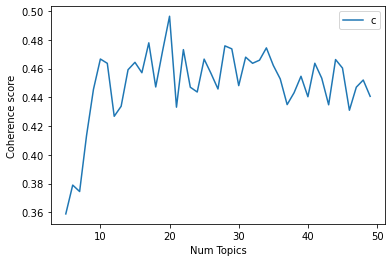

In [85]:
plt.plot(topic_nums, coherence_scores)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [15]:
num_topics = 20

In [16]:
nmf = Nmf(
    corpus=list(df_articles['corpus']),
    num_topics=num_topics,
    id2word=id2word,
    chunksize=2000,
    passes=5,
    kappa=.1,
    minimum_probability=0.01,
    w_max_iter=300,
    w_stop_condition=0.0001,
    h_max_iter=100,
    h_stop_condition=0.001,
    eval_every=10,
    normalize=True,
    random_state=42
)

In [17]:
df_articles['groups'] = df_articles['corpus'].apply(lambda x: nmf.get_document_topics(x))
df_articles['best_group'] = df_articles['groups'].apply(lambda x: max(x, key=itemgetter(1))[0] if x == x and len(x) > 0 else np.nan)
df_articles.head()

id                                              title  \
0  8061732                           Les Liaisons Dangereuses   
1  8183963  Il y a 15 ans, à l'Open d'Australie, Henin bat...   
2  8210435        Canada 1989: La première de Thierry Boutsen   
3  8214259  Recette de Candice : Gratin de pâtes de fin d'...   
4  8226512  Liège-Bastogne-Liège 1999: Vandenbroucke attei...   

                                                body  \
0  Considéré comme la meilleure adaptation du rom...   
1  Une finale disputée et un point contesté Contr...   
2  Mais à trois tours de la fin de la course, le ...   
3  500g de rigatoni (ou autres pâtes au choix) \t...   
4  Très à l'aise dans La Redoute, Vandenbroucke c...   

                                           word_list  \
0  [considere, comme, la, meilleure, adaptation, ...   
1  [une, finale, disputee, et, un, point, contest...   
2  [mais, trois, tours, de, la, fin, de, la, cour...   
3  [de, rigatoni, ou, autres, pates, au, choix, d...   
4  [tres, aise, dans, la, redoute, vandenbroucke,...   

                                     processed_words  word_count  \
0  [meilleur, adaptation, roman, choderlo, drame,...          35   
1  [finale, contrairement, precedente, finale, fa...          75   
2  [tour, fin, course, decide, improbable, produi...          43   
3  [chou, bruxelle, frais, coupe, cubes, gouda, c...          57   
4  [aise, redoute, double, attaque, hauteur, dans...          37   

                                              corpus  \
0  [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...   
1  [(30, 1), (31, 2), (32, 1), (33, 2), (34, 3), ...   
2  [(83, 1), (84, 1), (85, 2), (86, 2), (87, 1), ...   
3  [(90, 1), (96, 1), (97, 1), (117, 1), (118, 1)...   
4  [(86, 1), (146, 1), (156, 1), (157, 2), (158, ...   

                                              groups  best_group  
0  [(0, 0.1340299068050088), (1, 0.04759128519959...           9  
1  [(0, 0.24549511505441085), (1, 0.0181297985652...           0  
2  [(0, 0.066732061111838), (4, 0.032203139105988...          19  
3  [(0, 0.022018848670547375), (2, 0.010362022304...           8  
4  [(0, 0.03527871006760962), (1, 0.1751211476493...          10

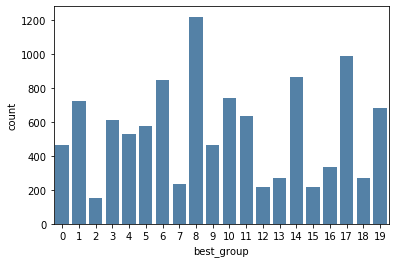

In [18]:
sns.countplot(x='best_group', data=df_articles, color='steelblue')

In [27]:
export_df(df_articles[['id', 'processed_words', 'word_count', 'corpus', 'groups', 'best_group']], 'topic_modeling_nmf')

In [ ]:
df_articles[df_articles['best_group'].isna()].shape

## Results visualization

In [79]:
[print(id2word[i]) for i in range(10)]

acteurs
adaptation
adolescente
amour
avec
bons
campe
ce
cecile
celle


[None, None, None, None, None, None, None, None, None, None]

In [67]:
df_articles[df_articles['best_group'] == 0].head(n=10)['corpus'].apply(lambda x: [y[0] for y in x])

42                                          [1406, 2335]
47         [231, 391, 500, 1357, 1495, 2465, 4414, 5486]
49                                    [1042, 1406, 2335]
54     [165, 209, 220, 391, 536, 629, 639, 703, 1409,...
125    [200, 926, 1303, 5816, 6409, 8440, 9567, 9573,...
128    [120, 328, 391, 447, 1038, 1222, 2039, 2227, 2...
134    [126, 391, 442, 629, 895, 956, 1022, 1064, 123...
138    [81, 120, 365, 377, 531, 786, 1142, 1303, 1724...
139                                   [1406, 5586, 7994]
185               [250, 6452, 7492, 10365, 11068, 11071]
Name: corpus, dtype: object

In [92]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

/home/meili/anaconda3/envs/analytics/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/meili/anaconda3/envs/analytics/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/meili/anaconda3/envs/analytics/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

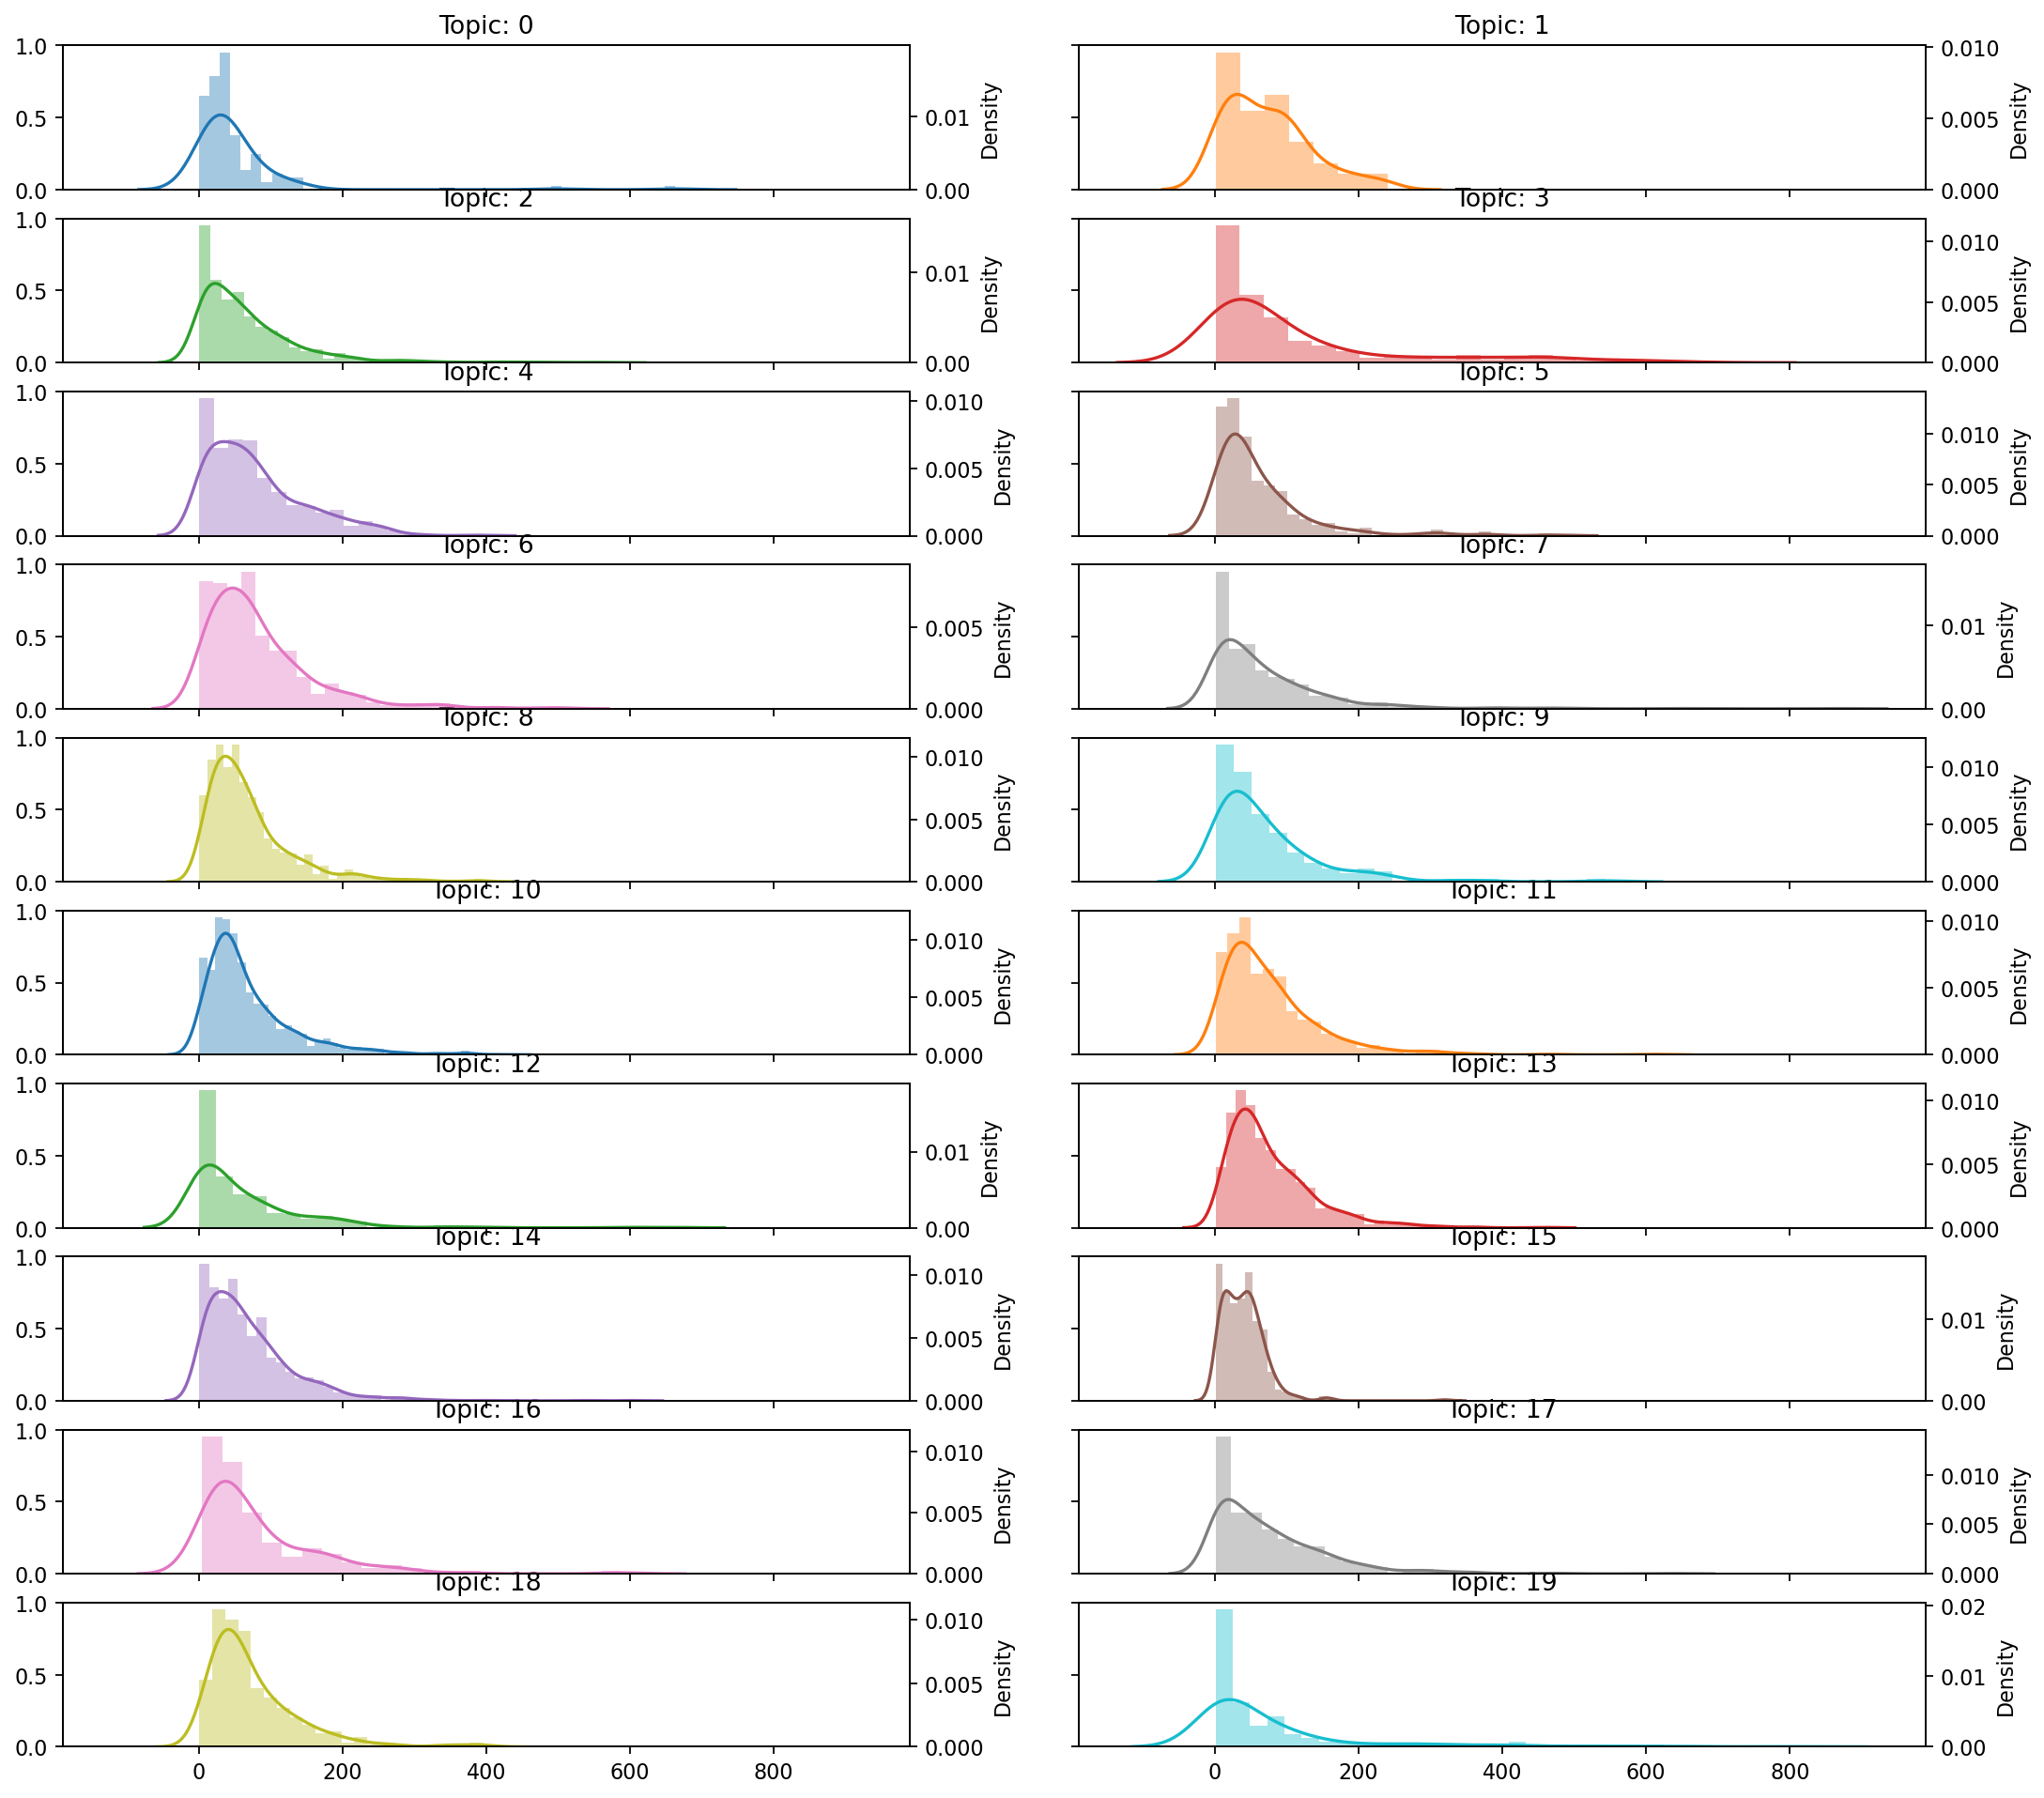

In [93]:
fig, axes = plt.subplots(int(num_topics/2),2,figsize=(16,15), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    sns.distplot(df_articles[(df_articles['word_count'] > 0) & (df_articles['best_group'] == i)]['word_count'], ax=ax.twinx(), color=cols[i%len(cols)])
    ax.set_title('Topic: {}'.format(i))

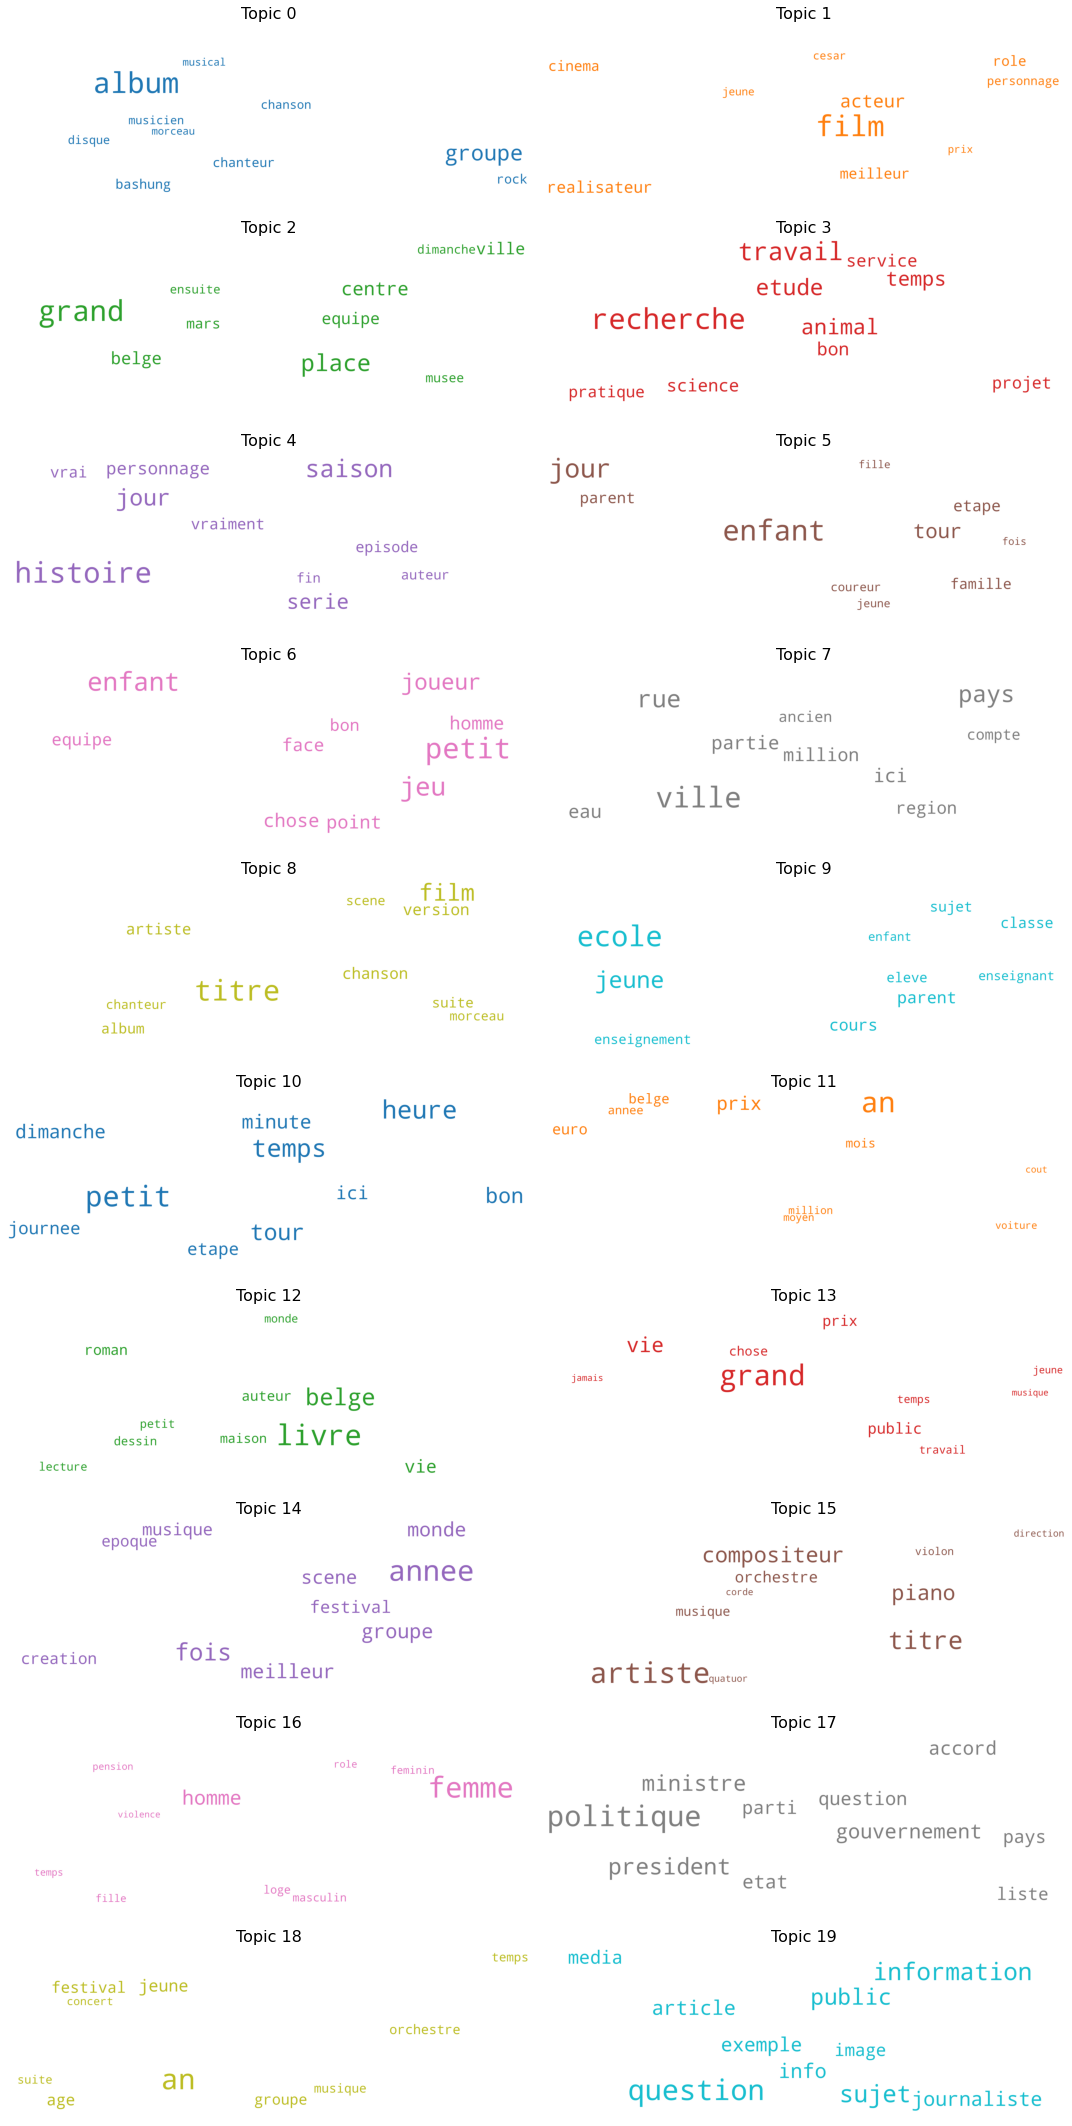

In [94]:
max_words = 10
cloud = WordCloud(stopwords=nlp.Defaults.stop_words,
                  background_color='white',
                  width=5500,
                  height=1800,
                  max_words=max_words,
                  color_func=lambda *args, **kwargs: cols[i%len(cols)],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(round(num_topics/2), 2, figsize=(15,30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict([(id2word[x[0]].replace("'",'').replace('"',''), x[1]) for x in nmf.get_topic_terms(i, max_words)])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

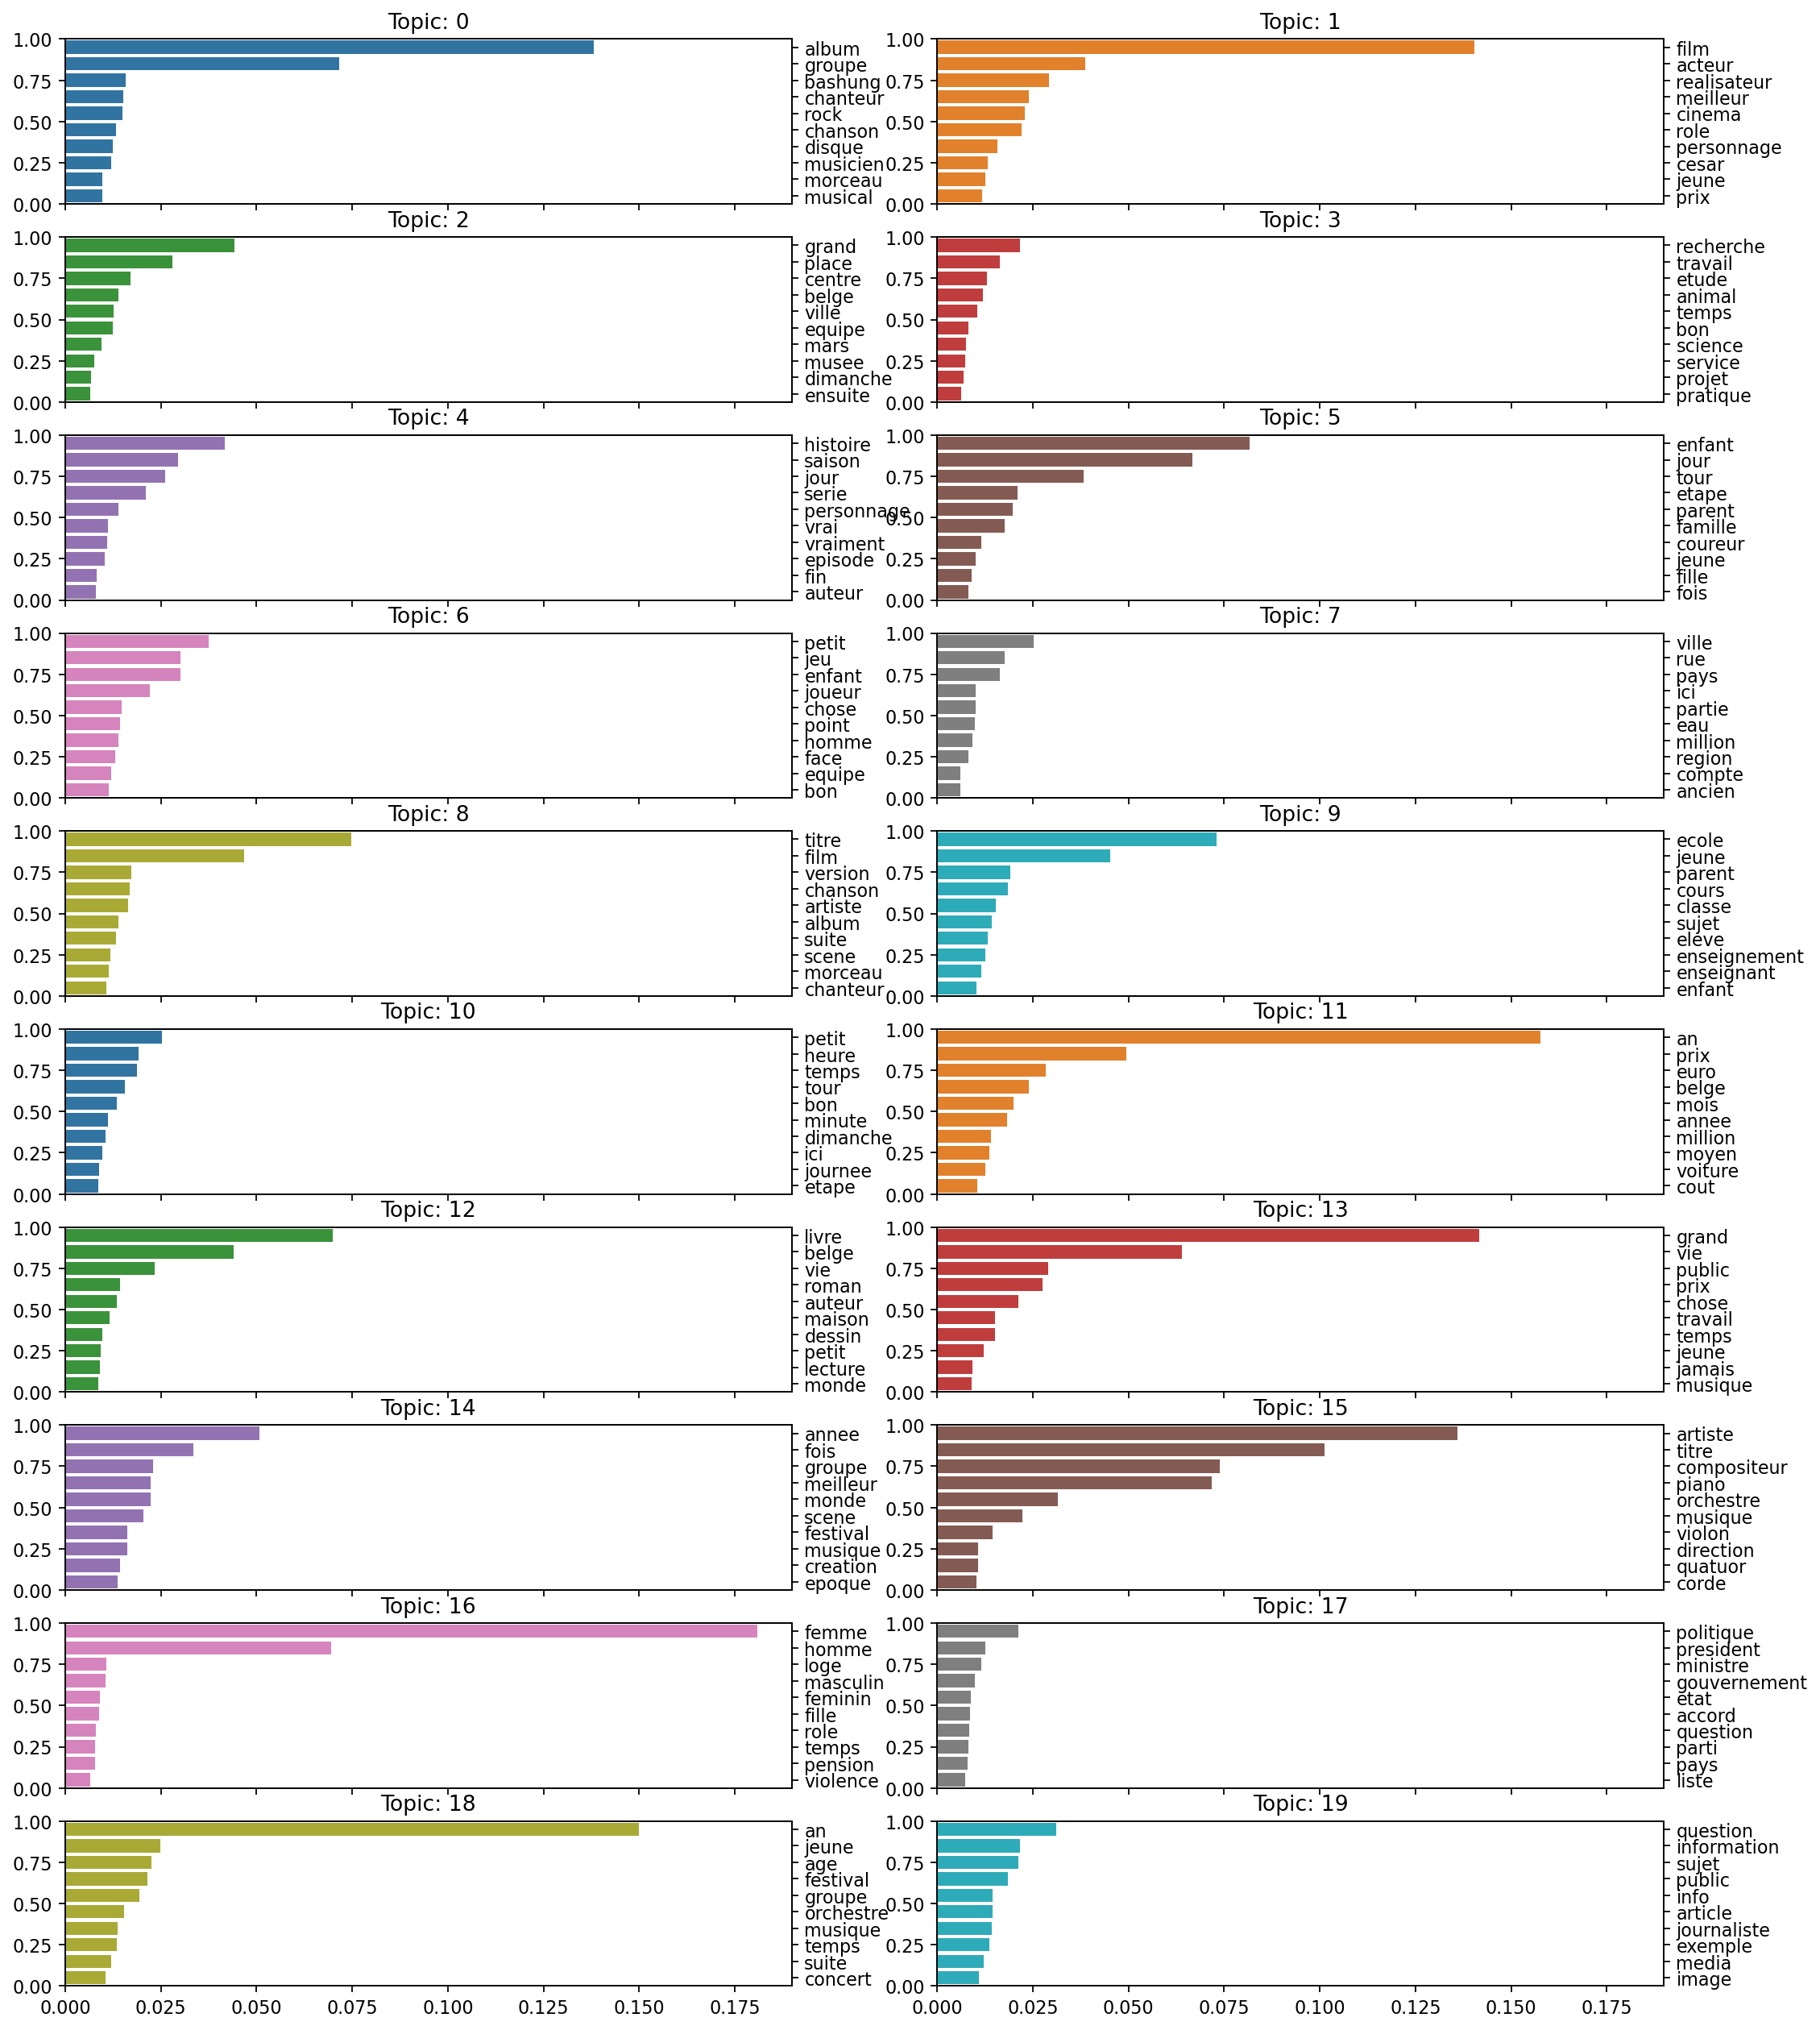

In [95]:
fig, axes = plt.subplots(int(num_topics/2),2,figsize=(16,15), dpi=160, sharex=True)

for i, ax in enumerate(axes.flatten()):    
    topics = dict([(id2word[x[0]].replace("'",'').replace('"',''), x[1]) for x in nmf.get_topic_terms(i, max_words)])
    sns.barplot(x=list(topics.values()), y=list(topics.keys()), ax=ax.twinx(), color=cols[i%len(cols)])
    ax.set_title('Topic: {}'.format(i))

In [96]:
for topic in range(num_topics):
    print('\nTOPIC {}'.format(topic))
    print([id2word[x[0]].replace("'",'').replace('"','') for x in nmf.get_topic_terms(i, max_words)])
    print(list(df_articles[df_articles['best_group'] == topic]['title']))


TOPIC 0
['question', 'information', 'sujet', 'public', 'info', 'article', 'journaliste', 'exemple', 'media', 'image']
['Nirvana: Joan Jett était terrorisée', 'Phoenix... Le nouvel album Rap Familial de Soprano. Best Of                              ', 'Snow Patrol, de retour avec son 7ème album', 'Que prépare Megadeth?', 'Tintin au Congo recolorisé sort en version numérique pour cause de polémique', 'Les sorties musicales à ne pas rater en 2019 !', 'Megadeth sortira 35 remasters', 'Les Cranberries sortent un album hommage à sa défunte chanteuse', 'The Germs: décès de Lorna Doom', 'Hugo Wolf - Italienisches Liederbuch - Diana Damrau, Jonas Kaufmann, Helmut Deutsch', 'Le nouveau Steve Hackett arrive!', "Vampire Weekend s'apprête à sortir un double album", 'Boogie Beasts en showcase: les images', 'Christophe Rousset\xa0: François Couperin, Les Nations', 'Hans Erich Apostel - Piano Music - Thérèse Malengreau', 'Parmi les artistes nommés aux D6bels Music Awards : Mustii, Kid Noize, Angèle..

In [97]:
df_articles['processed_words'].apply(lambda x: x)

0        [meilleur, adaptation, roman, choderlo, drame,...
1        [finale, contrairement, precedente, finale, fa...
2        [tour, fin, course, decide, improbable, produi...
3        [chou, bruxelle, frais, coupe, cubes, gouda, c...
4        [aise, redoute, double, attaque, hauteur, dans...
                               ...                        
11072    [recette, traditionnel, terroir, wallon, ingre...
11073    [acteur, politicien, elu, president, janvier, ...
11074    [heureusement, entreprise, importance, nature,...
11075    [traduction, eduardo, difficile, fils, legisla...
11076    [bibliotheque, inconnu, porte, passionnee, lec...
Name: processed_words, Length: 11077, dtype: object

In [31]:
for group in range(20):
    export_df(df_articles[df_articles['best_group']==group], 'group_{}'.format(group))

In [35]:
for i, row in df_articles.head(5):
    topic_percs, wordid_topics, wordid_phivalues = nmf[row['corpus']]
    print(wordid_topics)

TypeError: string indices must be integers

In [34]:
df_articles['corpus'].apply(lambda x: type(x))

0        <class 'list'>
1        <class 'list'>
2        <class 'list'>
3        <class 'list'>
4        <class 'list'>
              ...      
11072    <class 'list'>
11073    <class 'list'>
11074    <class 'list'>
11075    <class 'list'>
11076    <class 'list'>
Name: corpus, Length: 11077, dtype: object